In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scanpy
!pip install matplotlib==3.1.3
!pip install -U tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.2 MB/s 
     |████████████████████████████████| 88 kB 7.5 MB/s 
     |████████████████████████████████| 96 kB 5.3 MB/s 
     |████████████████████████████████| 11.2 MB 38.2 MB/s 
     |████████████████████████████████| 930 kB 52.9 MB/s 
     |████████████████████████████████| 1.1 MB 55.8 MB/s 
     |████████████████████████████████| 63 kB 602 kB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=431c55e911b9809dbbb8cafa5b8eab640e0f788d875748d18e01162516e74cca
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=1778eb225deb72df336be2602c5622e2e4224d96616218b710326a369a114e45
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 5.9 kB/s 
     |████████████████████████████████| 5.8 MB 35.3 MB/s 
     |████████████████████████████████| 438 kB 54.5 MB/s 
     |████████████████████████████████| 1.6 MB 47.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.

# Importing required libraries 

In [3]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import scipy

# Pancreatic Data 

## Data Treatment 

### Loading pancreatic data with cell cycle removed 

In [4]:
Pancreas_adata = sc.read_text('/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_LogX_CellCycleRegressedOut.txt', delimiter = '\t', first_column_names=None)
# Pancreas_adata = sc.read_text("/content/drive/MyDrive/pancreatic_gbm/Pancreas_LogX_CellCycleRegressedOut.txt", delimiter = '\t', first_column_names=None)
sc.pp.scale(Pancreas_adata)
Pancreas_adata

AnnData object with n_obs × n_vars = 2209 × 26179
    var: 'mean', 'std'

### Reading 13 unique pancreatic cell types from metadata 

In [5]:
PancreasMetadata = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/PancreasMetadata.csv")
# PancreasMetadata = pd.read_csv("/content/drive/MyDrive/pancreatic_gbm/PancreasMetadata.csv")
Pancreas_adata.obs['Cell Type'] = PancreasMetadata['Cell type'].values
Pancreas_adata.obs['Cell Type'].unique()

array(['γ', 'α', 'β', 'acinar', 'ε', 'unclassified exocrine', 'ductal',
       'δ', 'unclassified endocrine', 'endothelial', 'co-expression',
       'PSC', 'mast', 'MHC'], dtype=object)

### Copying cell ids (which are 2209 in number) from metadata and saving it as rows in adata

In [6]:
PancreasCellID = []
for item in PancreasMetadata['Cell ID'].values:
  PancreasCellID.append(item)
Pancreas_adata.obs_names = PancreasCellID
Pancreas_adata.obs_names

Index(['HP1502401_H13', 'HP1502401_J14', 'HP1502401_B14', 'HP1502401_A14',
       'HP1502401_C14', 'HP1502401_G14', 'HP1502401_E14', 'HP1502401_L14',
       'HP1502401_M14', 'HP1502401_K14',
       ...
       'HP1526901T2D_M7', 'HP1526901T2D_N16', 'HP1526901T2D_C8',
       'HP1526901T2D_H2', 'HP1526901T2D_I16', 'HP1526901T2D_F7',
       'HP1525301T2D_K3', 'HP1525301T2D_J10', 'HP1526901T2D_N8',
       'HP1526901T2D_A8'],
      dtype='object', length=2209)

### Copying genes from genelist (which is of 26179) and saving it as columns in adata

In [7]:
# PancreasGenes = pd.read_csv("/content/drive/MyDrive/pancreatic_gbm/Pancreas_Genelist.txt",header=None)
PancreasGenes = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_Genelist.txt",header=None)
PancreasGenelist = []
for item in PancreasGenes.values.tolist():
  PancreasGenelist.append(item[0])
Pancreas_adata.var_names = PancreasGenelist
Pancreas_adata.var_names

Index(['SGIP1', 'AZIN2', 'CLIC4', 'AGBL4', 'NECAP2', 'SLC45A1', 'TGFBR3',
       'DBT', 'RFWD2', 'C1orf21',
       ...
       'KIR3DS1', 'KIR2DL5B', 'KIR2DS2', 'KIR2DS1', 'KIR2DL2', 'KIR2DL4',
       'KIR2DS3', 'KIR2DS2', 'BIVM-ERCC5', 'ERCC_30000:mix1_7500:mix2'],
      dtype='object', length=26179)

### Excluding cells with not well-defined gene markers/excluding cells with cell type assignments that are not well-defined 

In [8]:
# Exclude cells with cell type assignments that are not well-defined 
# i.e. unclassified exocrine, unclassified endocrine, co-expression, MHC
# Pancreas_adata = Pancreas_adata[np.asarray(np.where(Pancreas_adata.obs['Cell Type'] != 'unclassified exocrine'))[0,:],:]
# Pancreas_adata = Pancreas_adata[np.asarray(np.where(Pancreas_adata.obs['Cell Type'] != 'unclassified endocrine'))[0,:],:]
# Pancreas_adata = Pancreas_adata[np.asarray(np.where(Pancreas_adata.obs['Cell Type'] != 'co-expression'))[0,:],:]
# Pancreas_adata = Pancreas_adata[np.asarray(np.where(Pancreas_adata.obs['Cell Type'] != 'MHC'))[0,:],:]

print(Pancreas_adata.shape)
Pancreas_adata.obs['Cell Type'].unique()

(2209, 26179)


array(['γ', 'α', 'β', 'acinar', 'ε', 'unclassified exocrine', 'ductal',
       'δ', 'unclassified endocrine', 'endothelial', 'co-expression',
       'PSC', 'mast', 'MHC'], dtype=object)

### Reading all of PangloaDB marker gene list 

In [9]:
# MarkerGeneList = pd.read_csv("/content/drive/MyDrive/pancreatic_gbm/PanglaoDB_Markers.tsv",sep='\t')
MarkerGeneList = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/PanglaoDB_Markers.tsv",sep='\t')

### Subsetting Panglao DB database for organ pancreas and species human 

In [10]:
PancreasMarkers = MarkerGeneList.iloc[np.asarray(np.where((MarkerGeneList['organ'] == 'Pancreas') & (MarkerGeneList['species'] != 'Mm')))[0,:],:]
PancreasMarkers

,species,official gene symbol,cell type,nicknames,ubiquitousness index,product description,gene type,canonical marker,germ layer,organ,sensitivity_human,sensitivity_mouse,specificity_human,specificity_mouse
0,Mm Hs,CTRB1,Acinar cells,CTRB,0.017,chymotrypsinogen B1,protein-coding gene,1.0,Endoderm,Pancreas,1.000000,0.957143,0.000629,0.015920
1,Mm Hs,KLK1,Acinar cells,Klk6,0.013,kallikrein 1,protein-coding gene,1.0,Endoderm,Pancreas,0.833333,0.314286,0.005031,0.012826
2,Mm Hs,RBPJL,Acinar cells,RBP-L|SUHL|RBPSUHL,0.001,recombination signal binding protein for immun...,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.000000,0.000000,0.000000
3,Mm Hs,PTF1A,Acinar cells,PTF1-p48|bHLHa29,0.001,pancreas associated transcription factor 1a,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.157143,0.000629,0.000773
5,Mm Hs,CELA3A,Acinar cells,ELA3|ELA3A,0.001,chymotrypsin like elastase family member 3A,protein-coding gene,1.0,Endoderm,Pancreas,0.833333,0.128571,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6374,Mm Hs,LRRTM1,Peri-islet Schwann cells,FLJ32082,0.005,leucine rich repeat transmembrane neuronal 1,protein-coding gene,NaN,Endoderm,Pancreas,0.000000,0.300000,0.001567,0.006292
6375,Mm Hs,SEMA3B,Peri-islet Schwann cells,SemA|semaV|LUCA-1|sema5|SEMAA,0.009,semaphorin 3B,protein-coding gene,NaN,Endoderm,Pancreas,1.000000,0.000000,0.017549,0.000000
6376,Mm Hs,NGFR,Peri-islet Schwann cells,TNFRSF16|CD271|p75NTR,0.007,nerve growth factor receptor,protein-coding gene,NaN,Endoderm,Pancreas,1.000000,1.000000,0.001880,0.006806
6377,Mm Hs,PNLIPRP1,Peri-islet Schwann cells,PLRP1,0.008,pancreatic lipase related protein 1,protein-coding gene,NaN,Endoderm,Pancreas,0.000000,0.200000,0.001880,0.009310


### Unqiue cell types for all data from panglao

In [11]:
pd.unique(MarkerGeneList['cell type'])

array(['Acinar cells', 'Adipocyte progenitor cells', 'Adipocytes',
       'Adrenergic neurons', 'Airway epithelial cells',
       'Airway goblet cells', 'Airway smooth muscle cells', 'Alpha cells',
       'Alveolar macrophages', 'Anterior pituitary gland cells',
       'Astrocytes', 'B cells', 'B cells memory', 'B cells naive',
       'Basal cells', 'Basophils', 'Bergmann glia', 'Beta cells',
       'Cajal-Retzius cells', 'Cardiac stem and precursor cells',
       'Cardiomyocytes', 'Cholangiocytes', 'Cholinergic neurons',
       'Chondrocytes', 'Choroid plexus cells', 'Chromaffin cells',
       'Ciliated cells', 'Clara cells', 'Crypt cells', 'Decidual cells',
       'Delta cells', 'Dendritic cells', 'Distal tubule cells',
       'Dopaminergic neurons', 'Ductal cells', 'Embryonic stem cells',
       'Endothelial cells', 'Endothelial cells (aorta)',
       'Endothelial cells (blood brain barrier)', 'Enteric glia cells',
       'Enteric neurons', 'Enterochromaffin cells', 'Enterocytes',
 

### Unique cell types for all data from panglao subsetted for pancreas and species human 

In [12]:
pd.unique(PancreasMarkers['cell type'])

array(['Acinar cells', 'Alpha cells', 'Beta cells', 'Delta cells',
       'Ductal cells', 'Epsilon cells', 'Gamma (PP) cells',
       'Pancreatic progenitor cells', 'Pancreatic stellate cells',
       'Peri-islet Schwann cells'], dtype=object)

In [13]:
# Reading rows depicting unqiue cell types in pancreas_adata object 
Pancreas_adata.obs['Cell Type'].unique()

array(['γ', 'α', 'β', 'acinar', 'ε', 'unclassified exocrine', 'ductal',
       'δ', 'unclassified endocrine', 'endothelial', 'co-expression',
       'PSC', 'mast', 'MHC'], dtype=object)

### Manually manipulating Marker Gene List 

In [14]:
# Manually get rid of unwanted cell types: Pancreatic progenitor cells and Peri-islet Schwann cells 
PancreasMarkers = PancreasMarkers.iloc[np.asarray(np.where(PancreasMarkers['cell type'] != 'Pancreatic progenitor cells'))[0,:],:]
PancreasMarkers = PancreasMarkers.iloc[np.asarray(np.where(PancreasMarkers['cell type'] != 'Peri-islet Schwann cells'))[0,:],:]

# Manually add cell types: endocrine, endothelial, mast, MHC (dendritic, macrophages, B cells)
# unclassified exocrine cells are also acinar cells; co-expression is not a defined cell type
# PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Enteroendocrine cells'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Endothelial cells'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Mast cells'))[0,:],:])
# PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Dendritic cells'))[0,:],:])
# PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Macrophages'))[0,:],:])
# PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'B cells'))[0,:],:])

pd.unique(PancreasMarkers['cell type'])

array(['Acinar cells', 'Alpha cells', 'Beta cells', 'Delta cells',
       'Ductal cells', 'Epsilon cells', 'Gamma (PP) cells',
       'Pancreatic stellate cells', 'Endothelial cells', 'Mast cells'],
      dtype=object)

In [15]:
PancreasMarkers['cell type'] = PancreasMarkers['cell type'].replace(['B cells', 'Macrophages', 'Dendritic cells'],
                                                                    'MHC')
pd.unique(PancreasMarkers['cell type'])

array(['Acinar cells', 'Alpha cells', 'Beta cells', 'Delta cells',
       'Ductal cells', 'Epsilon cells', 'Gamma (PP) cells',
       'Pancreatic stellate cells', 'Endothelial cells', 'Mast cells'],
      dtype=object)

### Showing that 587 genes are overlapping between our data and panglao db

In [16]:
# Pancreas Markers = marker gene list subsetted for organ pancreas and species human, unwanted cell types removed 
PanglaoDB_Pancreas = PancreasMarkers['official gene symbol']
PanglaoDB_Pancreas = list(set(PanglaoDB_Pancreas) & set(Pancreas_adata.var_names)) # overlap between dataset gene list and the PanglaoDB set 
len(PanglaoDB_Pancreas)

587

In [17]:
# Pancreas_adata.write(filename="/content/drive/My Drive/ML4FG 2022/Data/Pancreas Data/Processed/Pancreas_CellCycleRegressedOut_AnnData.h5ad")

In [18]:
# Create a variable list for input genes / features 

Panglao_Input = []

for i in range(Pancreas_adata.shape[1]):
  if Pancreas_adata.var_names[i] in set(PanglaoDB_Pancreas):
    Panglao_Input.append(True)
  else: 
    Panglao_Input.append(False)

Pancreas_adata.var['input_features'] = Panglao_Input
Pancreas_adata.var['input_features']


SGIP1                        False
AZIN2                        False
CLIC4                         True
AGBL4                        False
NECAP2                       False
                             ...  
KIR2DL4                      False
KIR2DS3                      False
KIR2DS2                      False
BIVM-ERCC5                   False
ERCC_30000:mix1_7500:mix2    False
Name: input_features, Length: 26179, dtype: bool

In [19]:
# Create anndata input for the model by filtering Pancreas_adata

Pancreas_input = Pancreas_adata[:,Pancreas_adata.var['input_features']]
Pancreas_input

View of AnnData object with n_obs × n_vars = 2209 × 593
    obs: 'Cell Type'
    var: 'mean', 'std', 'input_features'

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# device = 'cpu'

cuda


In [21]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## Sparse Model with zero weights for non-marker gene connections 

### Creating autoencoder model 

In [22]:
# same structure as pytorch model with no enforced barriers on weights 
class Autoencoder(Model):
    def __init__(self, num_cell_types, num_genes, weight_mask):
        super(Autoencoder, self).__init__()  
        self.encoder_weight_mask = tf.keras.backend.constant(weight_mask) 
        self.decoder_weight_mask = tf.keras.backend.constant(weight_mask.T)
        self.mean_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_constraint=NonNegative(self.encoder_weight_mask)),
        ])
        self.var_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_constraint=NonNegative(self.encoder_weight_mask)),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, activation='linear', 
                      kernel_constraint=NonNegative(self.decoder_weight_mask))
        ])

    def reparameterization(self, mean, var):
        epsilon = tf.random.normal(shape = [mean.shape[1]])             
        z = mean + (var*epsilon)                       
        return z
        
    def call(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        z = self.reparameterization(mean, tf.exp(0.5 * log_var))
        p = tf.keras.activations.softmax(z)
        decoded = self.decoder(p)
        return decoded

    def embed(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        var = tf.exp(0.5 * log_var)
        return tf.keras.activations.softmax(mean), mean, var

    def encoder_marker_gene_regularizer(self, w):
      return tf.reduce_sum(self.reg_penalties * tf.square(w))

    def decoder_marker_gene_regularizer(self, w):
      return tf.reduce_sum(self.reg_penalties.T * tf.square(w))

### Creating weight mask for marker genes

Since the weight mask is only for marker genes, the mask will be zero for non-marker genes.

In [23]:
marker_genes = Pancreas_input.var_names
cell_types = pd.unique(PancreasMarkers['cell type'])

marker_gene_cell_type_weight_mask = np.zeros((len(marker_genes), len(cell_types)))
for i, gene in enumerate(marker_genes):
  for j, cell_type in enumerate(cell_types):
    is_marker_gene_for_cell_type = \
      PancreasMarkers[(PancreasMarkers['official gene symbol'] == gene) & 
                      (PancreasMarkers['cell type'] == cell_type)].shape[0] > 0
    if is_marker_gene_for_cell_type:   # Mask = 1
      marker_gene_cell_type_weight_mask[i, j] = 1
    else:                              # Mask = 0
      marker_gene_cell_type_weight_mask[i, j] = 0

print(marker_gene_cell_type_weight_mask.shape)
marker_gene_cell_type_weight_mask

(593, 10)


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Creating Keras Layer constraint 

We create the constraint in such a way that the weight matrix is multiplied with the weight mask. The non-marker gene weights are masked by making them zero. 

In [24]:
class NonNegative(tf.keras.constraints.Constraint):

  def __init__(self, weight_mask):
    self.weight_mask = weight_mask

# Multiply the weight matrix by weight mask

  def __call__(self, w):
    w = w * self.weight_mask                                    # make weights sparse
    return w * tf.cast(tf.math.greater_equal(w, 0.), w.dtype)   # non-negative constraint 

 ### Fitting the model for 100 epochs. 

In [25]:
NumPancreasCellTypes = len(PancreasMarkers['cell type'].unique())
num_genes = Pancreas_input.shape[1]
autoencoder = Autoencoder(NumPancreasCellTypes, num_genes, 
                          marker_gene_cell_type_weight_mask)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(Pancreas_input.X, Pancreas_input.X,
                          epochs=100,
                          shuffle=True,
                          validation_data=(Pancreas_input.X, Pancreas_input.X))

Epoch 1/100
70/70 [==============================] - 3s 8ms/step - loss: 0.9819 - val_loss: 0.9771
Epoch 2/100
70/70 [==============================] - 1s 8ms/step - loss: 0.9721 - val_loss: 0.9662
Epoch 3/100
70/70 [==============================] - 0s 5ms/step - loss: 0.9616 - val_loss: 0.9566
Epoch 4/100
70/70 [==============================] - 1s 10ms/step - loss: 0.9527 - val_loss: 0.9481
Epoch 5/100
70/70 [==============================] - 0s 5ms/step - loss: 0.9448 - val_loss: 0.9405
Epoch 6/100
70/70 [==============================] - 0s 5ms/step - loss: 0.9372 - val_loss: 0.9333
Epoch 7/100
70/70 [==============================] - 0s 5ms/step - loss: 0.9303 - val_loss: 0.9267
Epoch 8/100
70/70 [==============================] - 0s 5ms/step - loss: 0.9238 - val_loss: 0.9204
Epoch 9/100
70/70 [==============================] - 0s 5ms/step - loss: 0.9177 - val_loss: 0.9145
Epoch 10/100
70/70 [==============================] - 0s 5ms/step - loss: 0.9120 - val_loss: 0.9090
Epoch 11

### Plotting training loss 

Text(0.5, 0, 'Epochs')

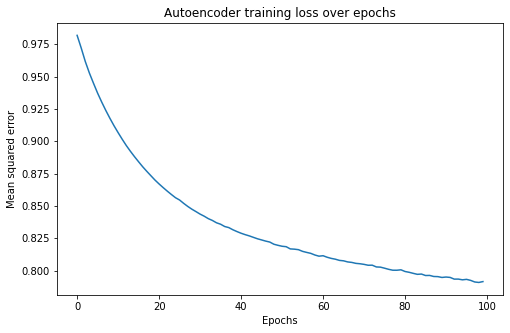

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.title('Autoencoder training loss over epochs')
plt.ylabel('Mean squared error')
plt.xlabel('Epochs')

### Predicting Cell Types 

These would be the predictions for the Custom Sparse Model with zero weights for non-marker gene connections 

In [27]:
def Compute_tTest(mean1,var1,mean2,var2,n):
  tScore = (mean1-mean2) / math.sqrt((var1+var2)/n)
  DegFreedom = ((((var1**2)+(var2**2))/n)**2) / ((((var1**2)+(var2**2))/(n**2))/(n-1))
  return scipy.stats.t.sf(abs(tScore), df=DegFreedom)

In [28]:
latent_embedding, mean, var = autoencoder.embed(Pancreas_input.X)
cell_type_labels = [cell_types[label] for label in 
                    tf.math.argmax(latent_embedding, axis=1).numpy()]

# compute pValue of each assignment and assign 'unknown' labels according p-value threshold
NumPancreasCells = Pancreas_input.shape[0]
Pancreas_Assignment_PValues = []
pVal_Threshold = 0.05

for cell in range(NumPancreasCells):
    MaxIndex = tf.math.argmax(latent_embedding[cell,:]).numpy()
    pVal = []
    for LatentNode in range(NumPancreasCellTypes):
      if LatentNode != MaxIndex:
        pVal.append(Compute_tTest(mean[cell,MaxIndex],var[cell,MaxIndex],
                                   mean[cell,LatentNode],var[cell,LatentNode],
                                   num_genes))
    Pancreas_Assignment_PValues.append(pVal[np.argmax(pVal)])
    if pVal[np.argmax(pVal)] > pVal_Threshold:
      print('Not Confident: ' + cell_type_labels[cell] + ' = ' + str(pVal[np.argmax(pVal)]))
      cell_type_labels[cell] = 'Unknown'

Pancreas_Assignment_PValues = np.array(Pancreas_Assignment_PValues).ravel()
Pancreas_adata.obs['Pancreas pVal'] = Pancreas_Assignment_PValues

Pancreas_adata.obs['Predicted Cell Type'] = cell_type_labels
Pancreas_input.obs['Predicted Cell Type'] = cell_type_labels

Not Confident: Acinar cells = 0.4153296131132722
Not Confident: Alpha cells = 0.4151129840727973
Not Confident: Ductal cells = 0.24316332499917714
Not Confident: Alpha cells = 0.41251288740669134
Not Confident: Ductal cells = 0.19540255660607248
Not Confident: Acinar cells = 0.23126693738412563
Not Confident: Epsilon cells = 0.2058595003601148
Not Confident: Gamma (PP) cells = 0.22120703772932632
Not Confident: Acinar cells = 0.0613933746962097
Not Confident: Beta cells = 0.2871677931346586
Not Confident: Beta cells = 0.27981159912186315
Not Confident: Delta cells = 0.4276812818692997
Not Confident: Endothelial cells = 0.4027160418262178


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


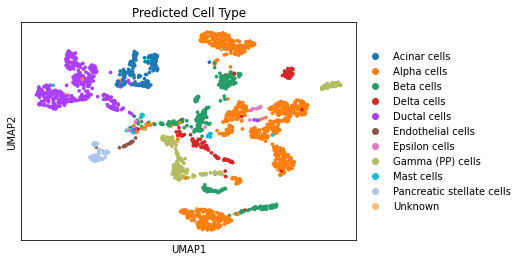

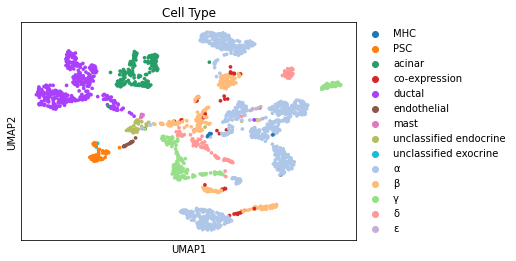

In [29]:
sc.tl.pca(Pancreas_adata, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(Pancreas_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(Pancreas_adata)

sc.pl.umap(Pancreas_adata, color=['Predicted Cell Type'])
sc.pl.umap(Pancreas_adata, color=['Cell Type'])

### Exporting predictions 

In [30]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/'
Pancreas_adata.obs.to_csv(dir + 'sparseVAE_pancreas_predictions.csv')

# GBM Data 

## Data Treatment 

In [31]:
# Read and process GBM data 


GBM_adata = sc.read_text("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/GBM_LogX.txt", delimiter = '\t', first_column_names=None)
GBM_adata = GBM_adata.T 

# Regress out cell cycle scores
GBMCellCycleScores = pd.read_table("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/GbmCellCycleScores.txt", delimiter = '\t')
GBM_adata.obs['score_S'] = GBMCellCycleScores['score_S'].values
GBM_adata.obs['score_G2M'] = GBMCellCycleScores['score_G2M'].values
sc.pp.regress_out(GBM_adata, ['score_S', 'score_G2M'])

# Scale (zero-center) data
sc.pp.scale(GBM_adata)

GBM_Metadata = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/metadata2.csv")
GBM_adata.obs['Cell Type'] = GBM_Metadata['cell_assignment'].values

GBMGenes = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/features2.tsv",header=None)
GBMGenelist = []
for item in GBMGenes.values.tolist():
  GBMGenelist.append(item[0])
GBM_adata.var_names = GBMGenelist
GBM_adata.var_names

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2MP1',
       'A4GALT', 'A4GNT', 'AA06',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=23686)

### Manually manipulating Marker Gene List for GBM data 

In [32]:
GBMMarkers = MarkerGeneList.iloc[np.asarray(np.where((MarkerGeneList['cell type'] == 'Oligodendrocytes') | 
                                                    (MarkerGeneList['cell type'] == 'T cells') |
                                                    (MarkerGeneList['cell type'] == 'Macrophages')))[0,:],:]

PanglaoDB_GBM = GBMMarkers['official gene symbol']
PanglaoDB_GBM = list(set(PanglaoDB_GBM) & set(GBM_adata.var_names))

# Manually add malignant gene markers 
MalignantGenesPool = ['CD133','CD44','ABCC3','TNFRSF1A','MGMT','IDH 1',
                      'IDH 2','ATRX','1p/19q','TP53','RB','PI3K','RKT',
                      'RAS','TERT','PTEN','EGFR']
MalignantGenes = []
for g in MalignantGenesPool:
  if ((g in GBM_adata.var_names) & (g not in PanglaoDB_GBM)):
    MalignantGenes.append(g)
MalignantGenes

# Create a variable list for input genes / features 
Panglao_GBM_Input = []

for i in range(GBM_adata.shape[1]):
  if GBM_adata.var_names[i] in set(PanglaoDB_GBM):
    Panglao_GBM_Input.append(True)
  else: 
    Panglao_GBM_Input.append(False)

GBM_adata.var['input_features'] = Panglao_GBM_Input

In [33]:
Malignant_df = pd.DataFrame({"official gene symbol":MalignantGenes, "cell type":['Malignant']*len(MalignantGenes)})
Malignant_df

,official gene symbol,cell type
0,CD44,Malignant
1,ABCC3,Malignant
2,TNFRSF1A,Malignant
3,MGMT,Malignant
4,ATRX,Malignant
5,TP53,Malignant
6,TERT,Malignant
7,PTEN,Malignant
8,EGFR,Malignant


In [34]:
len(PanglaoDB_GBM)

295

In [35]:
PanglaoDB_GBM = PanglaoDB_GBM + list(Malignant_df['official gene symbol'])
len(PanglaoDB_GBM)

304

In [36]:
GBMMarkers_list = []
for gene in PanglaoDB_GBM:
  if gene in list(GBMMarkers['official gene symbol']):
    GBMMarkers_list.append({
        'official gene symbol': gene,
        'cell type': GBMMarkers.loc[GBMMarkers['official gene symbol'] == gene, 'cell type'].iloc[0]
    })
        
GBMMarkers = pd.DataFrame(GBMMarkers_list)
print(GBMMarkers.shape)
GBMMarkers.head()

(295, 2)


,official gene symbol,cell type
0,S1PR4,T cells
1,KLK6,Oligodendrocytes
2,CD200R1,Macrophages
3,NR4A3,Macrophages
4,CLEC7A,Macrophages


In [37]:
GBMMarkers = pd.concat([GBMMarkers, Malignant_df])
print(GBMMarkers.shape)
GBMMarkers.head()

(304, 2)


,official gene symbol,cell type
0,S1PR4,T cells
1,KLK6,Oligodendrocytes
2,CD200R1,Macrophages
3,NR4A3,Macrophages
4,CLEC7A,Macrophages


In [38]:
# Create a variable list for input genes / features 
Panglao_GBM_Input = []

for i in range(GBM_adata.shape[1]):
  if GBM_adata.var_names[i] in PanglaoDB_GBM:
    Panglao_GBM_Input.append(True)
  else: 
    Panglao_GBM_Input.append(False)

GBM_adata.var['input_features'] = Panglao_GBM_Input

In [39]:
# Create anndata input for the model by filtering GBM_adata
GBM_input = GBM_adata[:,GBM_adata.var['input_features']]
GBM_input

View of AnnData object with n_obs × n_vars = 7930 × 304
    obs: 'score_S', 'score_G2M', 'Cell Type'
    var: 'mean', 'std', 'input_features'

In [40]:
cell_types = pd.unique(GBMMarkers['cell type'])
cell_types

array(['T cells', 'Oligodendrocytes', 'Macrophages', 'Malignant'],
      dtype=object)

## Model Creation 

### Creating weight mask for marker genes 

In [41]:
marker_genes = GBM_input.var_names
cell_types = pd.unique(GBMMarkers['cell type'])

marker_gene_cell_type_weight_mask = np.zeros((len(marker_genes), len(cell_types)))
for i, gene in enumerate(marker_genes):
  for j, cell_type in enumerate(cell_types):
    is_marker_gene_for_cell_type = \
      GBMMarkers[(GBMMarkers['official gene symbol'] == gene) & 
                      (GBMMarkers['cell type'] == cell_type)].shape[0] > 0
    if is_marker_gene_for_cell_type:   # Mask = 1
      marker_gene_cell_type_weight_mask[i, j] = 1
    else:                              # Mask = 0
      marker_gene_cell_type_weight_mask[i, j] = 0

print(marker_gene_cell_type_weight_mask.shape)
marker_gene_cell_type_weight_mask

(304, 4)


array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

### Fitting the model for 100 epochs 

In [42]:
NumGBMCellTypes = len(GBMMarkers['cell type'].unique())
num_genes = GBM_input.shape[1]
autoencoder = Autoencoder(NumGBMCellTypes, num_genes, 
                          marker_gene_cell_type_weight_mask)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(GBM_input.X, GBM_input.X,
                          epochs=100,
                          shuffle=True,
                          validation_data=(GBM_input.X, GBM_input.X))

Epoch 1/100
248/248 [==============================] - 2s 6ms/step - loss: 0.9872 - val_loss: 0.9734
Epoch 2/100
248/248 [==============================] - 1s 5ms/step - loss: 0.9624 - val_loss: 0.9514
Epoch 3/100
248/248 [==============================] - 1s 5ms/step - loss: 0.9421 - val_loss: 0.9330
Epoch 4/100
248/248 [==============================] - 1s 5ms/step - loss: 0.9253 - val_loss: 0.9178
Epoch 5/100
248/248 [==============================] - 1s 5ms/step - loss: 0.9115 - val_loss: 0.9044
Epoch 6/100
248/248 [==============================] - 1s 5ms/step - loss: 0.8990 - val_loss: 0.8929
Epoch 7/100
248/248 [==============================] - 1s 5ms/step - loss: 0.8881 - val_loss: 0.8825
Epoch 8/100
248/248 [==============================] - 1s 5ms/step - loss: 0.8782 - val_loss: 0.8741
Epoch 9/100
248/248 [==============================] - 1s 5ms/step - loss: 0.8698 - val_loss: 0.8656
Epoch 10/100
248/248 [==============================] - 1s 5ms/step - loss: 0.8620 - val_lo

### Plotting training loss 

Text(0.5, 0, 'Epochs')

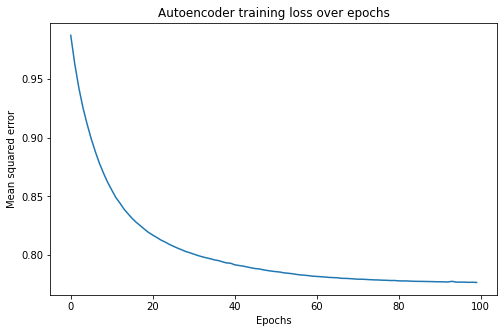

In [43]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.title('Autoencoder training loss over epochs')
plt.ylabel('Mean squared error')
plt.xlabel('Epochs')

### Predicting cell types 

In [48]:
latent_embedding, mean, var = autoencoder.embed(GBM_input.X)
cell_type_labels = []
for item in latent_embedding:
  cell_type_labels.append(cell_types[np.where(item == max(item))[0][0]])

# compute pValue of each assignment and assign 'unknown' labels according p-value threshold
NumGBMCells = GBM_input.shape[0]
GBM_Assignment_PValues = []
pVal_Threshold = 2

for cell in range(NumGBMCells):
    MaxIndex = tf.math.argmax(latent_embedding[cell,:]).numpy()
    pVal = []
    for LatentNode in range(NumGBMCellTypes):
      if LatentNode != MaxIndex:
        pVal.append(Compute_tTest(mean[cell,MaxIndex],var[cell,MaxIndex],
                                   mean[cell,LatentNode],var[cell,LatentNode],
                                   num_genes))
    GBM_Assignment_PValues.append(pVal[np.argmax(pVal)])
    if pVal[np.argmax(pVal)] > pVal_Threshold:
      print('Not Confident: ' + cell_type_labels[cell] + ' = ' + str(pVal[np.argmax(pVal)]))
      cell_type_labels[cell] = 'Unknown'

GBM_Assignment_PValues = np.array(GBM_Assignment_PValues).ravel()
GBM_adata.obs['GBM pVal'] = GBM_Assignment_PValues

GBM_adata.obs['Predicted Cell Type'] = cell_type_labels
GBM_input.obs['Predicted Cell Type'] = cell_type_labels

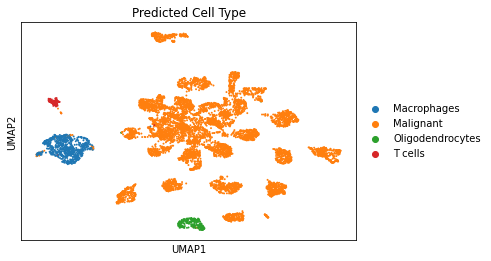

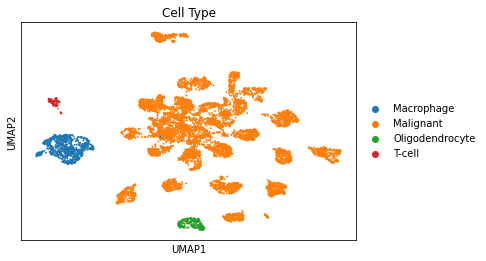

In [49]:
sc.tl.pca(GBM_adata, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(GBM_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(GBM_adata)

sc.pl.umap(GBM_adata, color=['Predicted Cell Type'])
sc.pl.umap(GBM_adata, color=['Cell Type'])

### Exporting predictions 

In [50]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/'
GBM_adata.obs.to_csv(dir + 'sparseVAE_GBM_predictions.csv')